In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval
from hyperopt.pyll import scope

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


## 1. Loading the dataset

In [2]:
train_df = pd.read_csv("./playground-series-s3e22/train.csv")
test_df = pd.read_csv("./playground-series-s3e22/test.csv")
originial_df = pd.read_csv("./playground-series-s3e22/horse.csv")

train_df.shape, test_df.shape, originial_df.shape

((1235, 29), (824, 28), (299, 28))

In [3]:
train_df = pd.concat([train_df, originial_df], ignore_index=True)
train_df.drop_duplicates(inplace=True)
train_df.shape

(1534, 29)

## 2. EDA

In [4]:
train_df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0.0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1.0,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2.0,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3.0,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4.0,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [5]:
train_df.outcome.unique()

array(['died', 'euthanized', 'lived'], dtype=object)

There are 3 possible outcomes of each horse treatment

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   float64
 1   surgery                1534 non-null   object 
 2   age                    1534 non-null   object 
 3   hospital_number        1534 non-null   int64  
 4   rectal_temp            1474 non-null   float64
 5   pulse                  1510 non-null   float64
 6   respiratory_rate       1476 non-null   float64
 7   temp_of_extremities    1478 non-null   object 
 8   peripheral_pulse       1465 non-null   object 
 9   mucous_membrane        1487 non-null   object 
 10  capillary_refill_time  1502 non-null   object 
 11  pain                   1479 non-null   object 
 12  peristalsis            1490 non-null   object 
 13  abdominal_distention   1478 non-null   object 
 14  nasogastric_tube       1430 non-null   object 
 15  naso

## 2.1 Dataset distribution by outcomes

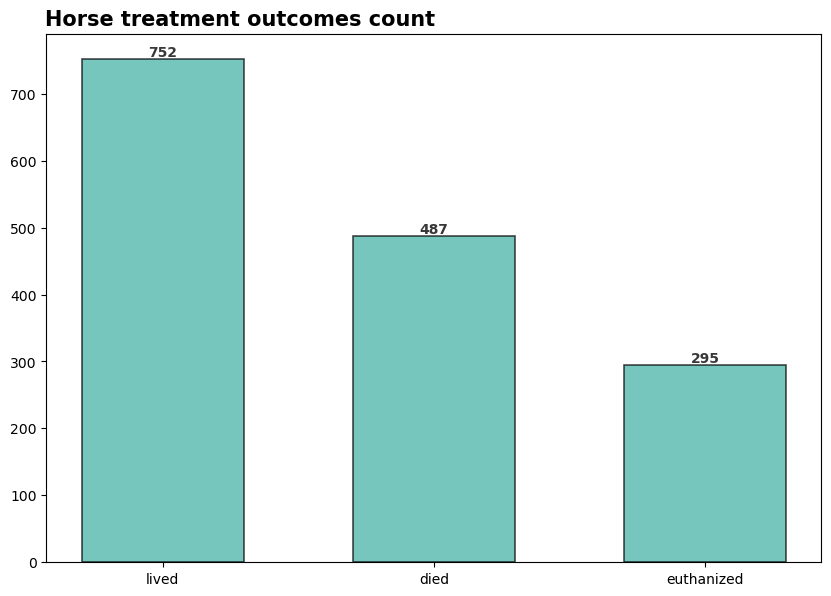

In [7]:


plt.figure(figsize=(10, 7), dpi=100)
plt.bar(train_df['outcome'].value_counts().keys(), train_df["outcome"].value_counts(), color='#3caea3',
        alpha=0.7, width=0.6, edgecolor='black', linewidth=1.2)
plt.title("Horse treatment outcomes count", fontsize=15, fontweight='bold', position=(0.25, 1.0+0.05))
for i in train_df["outcome"].unique():
    plt.annotate(f"{train_df['outcome'].value_counts()[i]}", 
                   xy=(i, train_df['outcome'].value_counts()[i] + 10),
                   va = 'center', ha='center',fontweight='bold', color='#383838'
                   )

Patients who lived make up almost 50% of the dataset

## 2.2 Correlation matrix

<ipython-input-8-1a1de0dc90ea>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df[list(train_df.columns)].corr()


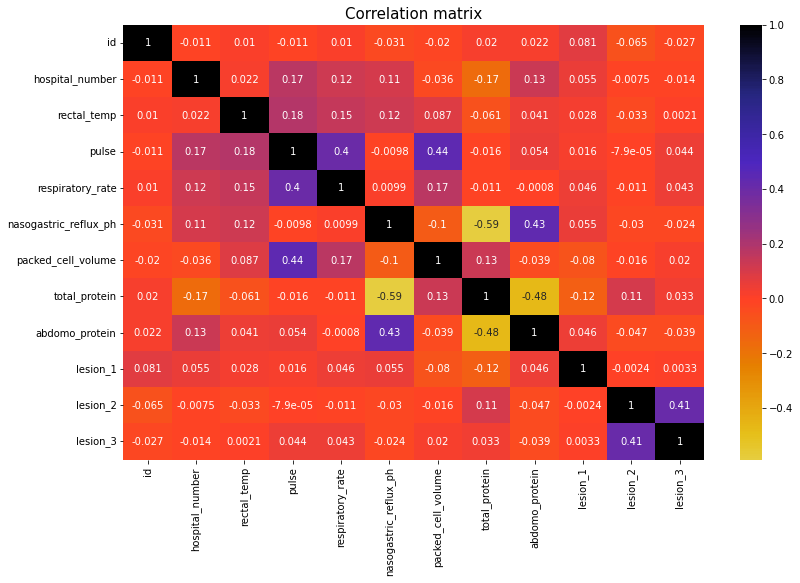

In [8]:
corr = train_df[list(train_df.columns)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap=plt.cm.CMRmap_r , annot = True, center = 0)
plt.title('Correlation matrix', fontsize = 15)
plt.show()


In [9]:
# Columns to encode with 2 unique values
cols_with_binary_values = train_df[[col for col in train_df.columns if len(train_df[col].unique()) == 2]].columns

In [10]:
# Columns to encode with more than 2 unique options
cols_with_more_than_3_values = train_df[[col for col in train_df.columns if (len(train_df[col].unique()) > 2 and
                                     col != "outcome" and
                                     train_df[col].dtype == 'O')]].columns
cols_with_more_than_3_values

Index(['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
       'abdomen', 'abdomo_appearance'],
      dtype='object')

In [11]:
# Finding columns with singlar unique value
for col in cols_with_more_than_3_values:
    potential_value = train_df[col].value_counts().loc[train_df[col].value_counts() == 1]
    if len(potential_value) > 0:
        print(potential_value)
    

slight    1
Name: pain, dtype: int64
distend_small    1
Name: peristalsis, dtype: int64
slight    1
Name: nasogastric_reflux, dtype: int64
serosanguious    1
Name: rectal_exam_feces, dtype: int64


In [12]:
numerical_columns = train_df[[col for col in train_df.columns if train_df[col].dtype==np.float64]].columns

## 3. Data preprocessing

In [13]:

def preprocess_df(df: pd.DataFrame, test_set: bool):
    df.copy()
    # 1. Binary encoding
    columns_to_binary_encode_yesno = ["surgery", "surgical_lesion", "cp_data"]
    for col in columns_to_binary_encode_yesno: 
        df[col] = df[col].eq("yes").mul(1)
    
    df["age"] = df["age"].eq("adult").mul(1)
    
    # 2. Remapping outcomes
    outcomes = {'lived': 0,
                'died': 1, 
                'euthanized': 2}

    if not test_set:
        df['outcome'] = df['outcome'].map(outcomes) 
        
    # 4. Encoding categorical features
    
    df["pain"] = df["pain"].replace("slight", "moderate")
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')
    
    # Mapping categorical features
    df["temp_of_extremities"] = df["temp_of_extremities"].map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3, 'None': 2})
    df["peripheral_pulse"] = df["peripheral_pulse"].map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3, 'None': 2})
    df["capillary_refill_time"] = df["capillary_refill_time"].map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2, 'None': 1})
    df["pain"] = df["pain"].map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5, 'None': 1})
    df["peristalsis"] = df["peristalsis"].map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3, 'None': 1})
    df["abdominal_distention"] = df["abdominal_distention"].map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3, 'None': 0})
    df["nasogastric_tube"] = df["nasogastric_tube"].map({'none': 0, 'slight': 1, 'significant': 2, 'None': 0})
    df["nasogastric_reflux"] = df["nasogastric_reflux"].map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2, 'None': 1})
    df["rectal_exam_feces"] = df["rectal_exam_feces"].map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3, 'None': 0})
    df["abdomen"] = df["abdomen"].map({'normal': 0, 'other': 1, 'firm': 2,'distend_small': 3, 'distend_large': 4, 'None': 3})
    df["abdomo_appearance"] = df["abdomo_appearance"].map({'clear': 0, 'cloudy': 1, 'serosanguious': 2, 'None': 2})
    
    
    # 6. Dropping rows with missing mucous_membrane
    df = df.dropna(subset=['mucous_membrane'])
    
    # 7. One hot encoding additional column
    df= pd.get_dummies(df, columns=["mucous_membrane"])
    
    # 8. Imputing missing values
    imputer = KNNImputer(n_neighbors=2)
    imputed = imputer.fit_transform(df)
    imputed_df = pd.DataFrame(imputed, columns=df.columns)
    
    # Columns with categorical data     
    cols_with_categorical_data = np.concatenate((cols_with_binary_values, cols_with_more_than_3_values))
    cols_with_categorical_data = np.delete(cols_with_categorical_data, np.where(cols_with_categorical_data == 'mucous_membrane'))
    
    # Rounding imputed values to represent nearest categorical data labels
    imputed_df[cols_with_categorical_data] = imputed_df[cols_with_categorical_data].apply(lambda x: round(x))
    
    df = imputed_df
    

    # 9. Dropping correlated dependent feature
    df.drop('lesion_3',axis=1,inplace=True)
        
    return df
    

In [14]:
def scale_features(df):
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns]) 
    
    return df
    

In [15]:
preprocessed_df = preprocess_df(train_df, False)


In [16]:
# preprocessed_df = scale_features(preprocessed_df)

In [17]:
cols_with_missing_values = preprocessed_df.columns[preprocessed_df.isnull().any()]
cols_with_missing_values

Index([], dtype='object')

All missing values have been filled

In [18]:
preprcessed_test_df = preprocess_df(test_df, True)

In [ ]:
# preprcessed_test_df = scale_features(preprcessed_test_df)

## 4. Modelling 1.0

In [20]:
X = preprocessed_df.drop(["outcome", "id"], axis=1)
y = preprocessed_df["outcome"]

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) 
kf = KFold(n_splits=8)

### 4.1 XGB (default)

In [ ]:
f1_scores_xgb = []

model__xgb_default = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror', 'mlogloss'], 
                            seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model__xgb_default.fit(X_train, 
                y_train,
                verbose=0,
                eval_set=[(X_train, y_train), (X_test, y_test)])
    
    xgb_def_preds = model__xgb_default.predict(X_test)
    
    f1_scores_xgb.append(f1_score(y_test, xgb_def_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_xgb)))


#### Tuning

In [ ]:
# Define the hyperparameter space
space = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 8, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBClassifier(objective='multi:softmax', 
                                  num_class=3,
                                  **params,
                                  seed=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

#### Tuned

In [30]:
f1_scores_xgb_tuned = []

model_xgb_tuned = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror', 'mlogloss'], 
                            learning_rate=0.0929001213267843,
                            max_depth=7,
                            subsample=0.5165249283838895,
                            seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_xgb_tuned.fit(X_train, 
                y_train,
                verbose=0,
                eval_set=[(X_train, y_train), (X_test, y_test)])
    
    xgb_def_preds = model_xgb_tuned.predict(X_test)
    
    f1_scores_xgb_tuned.append(f1_score(y_test, xgb_def_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_xgb_tuned)))

Average model F1 score: 0.7431742226097064


After tuning the average F1 Score increased by 1

### 4.2 CatBoost


In [ ]:

f1_scores_cat = []

cat_md = CatBoostClassifier(loss_function = 'MultiClass',
                                    iterations = 500,
                                    verbose = False, 
                                    task_type = 'GPU',
                                    random_seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    cat_md.fit(X_train, y_train)

    cat_pred = cat_md.predict(X_test) 
    
    f1_scores_cat.append(f1_score(y_test, cat_pred, average='micro'))
    
print("Average model F1 score: {}".format(np.average(f1_scores_cat)))

#### Tuning

In [ ]:
# define the search space for the hyperparameters
space = {'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
         'iterations': hp.randint('iterations',100,1000),
         'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
         'depth': hp.randint('depth',4,10)}

# define the objective function which for this model is the RMSE
def objective(search_space):
    model = CatBoostClassifier(**search_space,
                              loss_function='MultiClass',
                              early_stopping_rounds=100,
                              task_type = 'GPU',
                              random_seed=42)
    
    model.fit(X = X_train, y = y_train, verbose=False)
    y_pred = model.predict(X_test)
    score = f1_score(y_pred, y_test, average='micro')
    return {'loss': -score, 'status': STATUS_OK}

In [ ]:
# search for best parameters
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=50)

In [ ]:
# dict of the best params
hyperparams = space_eval(space, best_params)
hyperparams

#### Tuned

In [31]:

f1_scores_cat_tuned = []

cat_md_tuned = CatBoostClassifier(loss_function = 'MultiClass',
                                    iterations = 594,
                                    verbose = False, 
                                    task_type = 'GPU',
                                    early_stopping_rounds=100,
                                    depth=8,
                                    l2_leaf_reg=4,
                                    learning_rate=0.2805333293875,
                                    random_seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    cat_md_tuned.fit(X_train, y_train)

    cat_pred = cat_md_tuned.predict(X_test) 
    
    f1_scores_cat_tuned.append(f1_score(y_test, cat_pred, average='micro'))
    
print("Average model F1 score: {}".format(np.average(f1_scores_cat_tuned)))

Average model F1 score: 0.7216506829410055


### 4.3 LightGBM

In [ ]:
f1_scores_lgb = []

model_lgb_default = LGBMClassifier(num_iterations=300,
                                   max_depth=10,
                                   objective='multiclass',
                                   verbose=-1)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgb_default.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(10, verbose=False)], verbose=False)
    
    lgb_preds = model_lgb_default.predict(X_test)
    
    f1_scores_lgb.append(f1_score(y_test, lgb_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_lgb)))

#### Tuning

In [ ]:
# Search space

space = {
        'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
        'num_iterations': hp.randint('num_iterations', 100, 1000),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'subsample_for_bin': scope.int(hp.quniform('subsample_for_bin', 20000, 300000, 20000)),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
        'min_data_in_leaf': scope.int(hp.qloguniform('min_data_in_leaf', 1, 6, 1)),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'verbose': -1,
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
    }



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def objective(search_space):
    model = LGBMClassifier(**search_space,
                            max_depth=8,
                            objective='multiclass',
                            random_seed=42)
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(10, verbose=False)], verbose=False)
    y_pred = model.predict(X_test)
    score = f1_score(y_pred, y_test, average='micro')
    return {'loss': -score, 'status': STATUS_OK}


In [ ]:
# search for best parameters
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=50)

In [ ]:
# dict of the best params
hyperparams = space_eval(space, best_params)
hyperparams

#### Tuned

In [32]:
f1_scores_lgb_tuned = []

model_lgb_tuned = LGBMClassifier(num_iterations=252,
                                   max_depth=8,
                                   objective='multiclass',
                                   verbose=-1,
                                   bagging_fraction=0.7231034465658441,
                                   feature_fraction=0.5821614895839977,
                                   lambda_l1=5.427706788599808,
                                   lambda_l2=0.8044760526180615,
                                   learning_rate=0.06314706652404878,
                                   min_child_weight=0.0001701741731826891,
                                   min_data_in_leaf=45,
                                   num_leaves=63,
                                   subsample_for_bin=240000,
                                    )

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgb_tuned.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(10, verbose=False)], verbose=False)
    
    lgb_preds = model_lgb_tuned.predict(X_test)
    
    f1_scores_lgb_tuned.append(f1_score(y_test, lgb_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_lgb_tuned)))

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_fraction is set=0.7231034465658441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231034465658441
[LightGBM] [Warning] lambda_l1 is set=5.427706788599808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.427706788599808
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5821614895839977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5821614895839977
[LightGBM] [Warning] lambda_l2 is set=0.8044760526180615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8044760526180615
[LightGBM] [Warning] bagging_fraction is set=0.7231034465658441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231034465658441
[LightGBM] [Warning] lambda_l1 is set=5.427706788599808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.427706788599808
[LightGBM] [Warning] min_data_in_l

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_fraction is set=0.7231034465658441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231034465658441
[LightGBM] [Warning] lambda_l1 is set=5.427706788599808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.427706788599808
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5821614895839977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5821614895839977
[LightGBM] [Warning] lambda_l2 is set=0.8044760526180615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8044760526180615
[LightGBM] [Warning] bagging_fraction is set=0.7231034465658441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231034465658441
[LightGBM] [Warning] lambda_l1 is set=5.427706788599808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.427706788599808
[LightGBM] [Warning] min_data_in_l

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_fraction is set=0.7231034465658441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231034465658441
[LightGBM] [Warning] lambda_l1 is set=5.427706788599808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.427706788599808
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5821614895839977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5821614895839977
[LightGBM] [Warning] lambda_l2 is set=0.8044760526180615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8044760526180615
[LightGBM] [Warning] bagging_fraction is set=0.7231034465658441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231034465658441
[LightGBM] [Warning] lambda_l1 is set=5.427706788599808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.427706788599808
[LightGBM] [Warning] min_data_in_l

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_fraction is set=0.7231034465658441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231034465658441
[LightGBM] [Warning] lambda_l1 is set=5.427706788599808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.427706788599808
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5821614895839977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5821614895839977
[LightGBM] [Warning] lambda_l2 is set=0.8044760526180615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8044760526180615


/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_fraction is set=0.7231034465658441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231034465658441
[LightGBM] [Warning] lambda_l1 is set=5.427706788599808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.427706788599808
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.5821614895839977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5821614895839977
[LightGBM] [Warning] lambda_l2 is set=0.8044760526180615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8044760526180615
Average model F1 score: 0.7458369659982563


After tuning the F1 score increased by 2

### 4.4 RandomForestClassifier

#### Default

In [22]:
f1_scores_rfc_default = []

model_rfc_default = RandomForestClassifier(n_estimators=200,
                                           max_depth=7,
                                           verbose=0,
                                           random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_rfc_default.fit(X_train, y_train)
    
    rfc_preds = model_rfc_default.predict(X_test)
    
    f1_scores_rfc_default.append(f1_score(y_test, rfc_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_rfc_default)))

Average model F1 score: 0.7169318512060447


#### Tuning

In [23]:
space = {
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_depth': hp.randint('max_depth', 5, 100),
    'max_features': hp.choice('max_features', ['auto', 'sqrt']),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 7, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'n_estimators': hp.randint('n_estimators', 200, 1000)
}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
def objective(search_space):
    model = RandomForestClassifier(**search_space,
                                   random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_pred, y_test, average='micro')
    return {'loss': -score, 'status': STATUS_OK}

In [26]:
# search for best parameters
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=50)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



  2%|▏         | 1/50 [00:00<00:37,  1.31trial/s, best loss: -0.7550335570469798]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



  4%|▍         | 2/50 [00:01<00:28,  1.67trial/s, best loss: -0.761744966442953] 

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



  6%|▌         | 3/50 [00:01<00:28,  1.62trial/s, best loss: -0.761744966442953]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 14%|█▍        | 7/50 [00:05<00:33,  1.28trial/s, best loss: -0.761744966442953]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 18%|█▊        | 9/50 [00:06<00:34,  1.20trial/s, best loss: -0.761744966442953]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 24%|██▍       | 12/50 [00:09<00:27,  1.39trial/s, best loss: -0.761744966442953]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 60%|██████    | 30/50 [00:17<00:11,  1.67trial/s, best loss: -0.7718120805369127]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 62%|██████▏   | 31/50 [00:18<00:10,  1.73trial/s, best loss: -0.7718120805369127]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 66%|██████▌   | 33/50 [00:19<00:10,  1.62trial/s, best loss: -0.7718120805369127]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 72%|███████▏  | 36/50 [00:21<00:07,  1.79trial/s, best loss: -0.7718120805369127]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 78%|███████▊  | 39/50 [00:23<00:06,  1.76trial/s, best loss: -0.7718120805369127]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 84%|████████▍ | 42/50 [00:24<00:04,  1.84trial/s, best loss: -0.7718120805369127]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 92%|█████████▏| 46/50 [00:28<00:03,  1.31trial/s, best loss: -0.7718120805369127]

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



100%|██████████| 50/50 [00:31<00:00,  1.61trial/s, best loss: -0.7718120805369127]


In [27]:
# dict of the best params
hyperparams = space_eval(space, best_params)
hyperparams

{'bootstrap': True,
 'max_depth': 26,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 395}

#### Tuned

In [28]:
f1_scores_rfc_tuned = []

model_rfc_tuned = RandomForestClassifier(n_estimators=395,
                                           max_depth=26,
                                           verbose=0,
                                           bootstrap=True,
                                           max_features='sqrt',
                                           min_samples_leaf=1,
                                           min_samples_split=3,
                                           random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_rfc_tuned.fit(X_train, y_train)
    
    rfc_preds = model_rfc_tuned.predict(X_test)
    
    f1_scores_rfc_tuned.append(f1_score(y_test, rfc_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_rfc_tuned)))

Average model F1 score: 0.7317313281022959


The average score increased by 1.5 after tuning

### 4.5 HistGradientBoostingClassifier

#### Default

In [29]:
f1_scores_hist_default = []

model_hist_default = HistGradientBoostingClassifier(random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_hist_default.fit(X_train, y_train)
    
    hist_preds = model_hist_default.predict(X_test)
    
    f1_scores_hist_default.append(f1_score(y_test, hist_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_hist_default)))

Average model F1 score: 0.7357744841615809


#### Tuning

## 5. Prediction and submission

In [33]:
preprcessed_test_df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,...,lesion_1,lesion_2,cp_data,mucous_membrane_None,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink
0,1235.0,0.0,1.0,534053.0,38.6,40.0,20.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1236.0,1.0,1.0,528469.0,38.2,112.0,48.0,1.0,1.0,2.0,...,2208.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1237.0,1.0,1.0,528178.0,37.7,66.0,12.0,1.0,2.0,0.0,...,2205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1238.0,0.0,1.0,534784.0,37.1,88.0,20.0,1.0,1.0,0.0,...,1400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1239.0,1.0,1.0,529840.0,38.3,50.0,12.0,2.0,2.0,0.0,...,2208.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [34]:
preprcessed_test_df.drop(['id'], axis=1, inplace=True)

In [35]:
xgb_predictions = model_xgb_tuned.predict(preprcessed_test_df)

In [36]:
cat_predictions = cat_md_tuned.predict(preprcessed_test_df)

In [37]:
lgb_predictions = model_lgb_tuned.predict(preprcessed_test_df)

In [38]:
rfc_predictions = model_rfc_tuned.predict(preprcessed_test_df)

In [39]:
hist_predictions = model_hist_default.predict(preprcessed_test_df)

In [40]:
predictions = pd.concat([pd.Series(xgb_predictions.flatten()),
                         pd.Series(cat_predictions.flatten()),
                         pd.Series(lgb_predictions.flatten()),
                         pd.Series(rfc_predictions.flatten()),
                         pd.Series(hist_predictions.flatten())], axis=1)
predictions

,0,1,2,3,4
0,0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,1.0
2,0,0.0,0.0,0.0,0.0
3,2,2.0,2.0,2.0,2.0
4,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
819,1,1.0,1.0,1.0,1.0
820,2,2.0,2.0,2.0,2.0
821,1,1.0,1.0,1.0,1.0
822,0,0.0,0.0,0.0,0.0


In [41]:
predictions_ensemble = mode(predictions, axis=1, keepdims=True)[0]

In [42]:
predictions_ensemble

array([[0.],
       [1.],
       [0.],
       [2.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [2.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [2.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [2.],
       [1.],
       [2.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [2.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [2.],
       [1.],
       [2.],

In [43]:
submission = pd.read_csv("./playground-series-s3e22/sample_submission.csv")
submission

,id,outcome
0,1235,lived
1,1236,lived
2,1237,lived
3,1238,lived
4,1239,lived
...,...,...
819,2054,lived
820,2055,lived
821,2056,lived
822,2057,lived


In [44]:

submission['outcome'] = predictions_ensemble
submission['outcome'] = submission['outcome'].map({0: 'lived', 1: 'died', 2: 'euthanized'})
submission.to_csv('predictions.csv', index = False)
submission.head()

,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,euthanized
4,1239,lived
